Connected to .venv (Python 3.8.10)

In [1]:
# ask about adding this to default profile on threadripper
from IPython import get_ipython
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")
import os
if "CONDA_PREFIX" in os.environ:
    os.environ.__delitem__("CONDA_PREFIX")

import numpy as np
import hcipy as hc
from copy import copy
from matplotlib import pyplot as plt
from hcipy import imshow_field
from photonics import DATA_PATH
from photonics.utils import rms, lmap
from photonics.second_stage_optics import SecondStageOptics
from juliacall import Main as jl
jl.seval("using Flux")
jl.seval("using JLD2")

/home/lab/asengupta/photonics/.venv/lib/python3.8/site-packages/juliacall/__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
sso = SecondStageOptics()
max_amp_nn = 0.5
model_fname = f"pl_nn_{max_amp_nn}"
model_state = jl.JLD2.load(DATA_PATH + f"/pl_nn/{model_fname}.jld2", "model_state")
if model_fname.endswith("19"):
    nzern = 19
    model = jl.Chain(
        jl.Dense(19, 2000, jl.relu),
        jl.Dense(2000, 100, jl.relu),
        jl.Dropout(0.2),
        jl.Dense(100, 19)
    )
else:
    nzern = 9
    model = jl.Chain(
        jl.Dense(19, 2000, jl.relu),
        jl.Dense(2000, 100, jl.relu),
        jl.Dense(100, 9)
    )

jl.Flux.loadmodel_b(model, model_state)
ymin, ymax = (lambda x: (np.min(x), np.max(x)))(np.abs(np.load(DATA_PATH + "/sim_trainsets/sim_trainset_lanterns_240502_1947.npy")) ** 2)
zernike_basis = hc.mode_basis.make_zernike_basis(nzern, sso.telescope_diameter, sso.pupil_grid)

def nn_inject_recover(zernikes, amplitudes):
    phase_screen = sso.zernike_to_phase(zernikes, amplitudes)
    psf = sso.focal_propagator(
        hc.Wavefront(sso.aperture * np.exp(1j * phase_screen), sso.wl)
    )
    post_lantern_coeffs = sso.lantern_optics.lantern_coeffs(psf)
    intensities = np.abs(post_lantern_coeffs) ** 2
    norm_intensities = ((intensities - ymin) / (ymax - ymin)).astype(np.float32)
    reconstructed_zernike_coeffs = np.array(model(norm_intensities)) * 0.5 - 0.25
    return reconstructed_zernike_coeffs

def nanify(phase_screen):
    x = copy(phase_screen)
    x = x - np.mean(x)
    x[np.where(sso.aperture == 0)] = np.nan
    return hc.Field(x, phase_screen.grid)

def reconstruct(phase_screen, plot=True):
    """
    Takes in a post-DM phase screen and injects and recovers it from the lantern.
    """
    phase_screen_coeffs = zernike_basis.coefficients_for(phase_screen - np.mean(phase_screen))
    phase_screen_projected = zernike_basis.linear_combination(phase_screen_coeffs)
    psf = sso.focal_propagator(
        hc.Wavefront(sso.aperture * np.exp(1j * phase_screen_projected), sso.wl)
    )
    post_lantern_coeffs = sso.lantern_optics.lantern_coeffs(psf)
    intensities = np.abs(post_lantern_coeffs) ** 2
    norm_intensities = ((intensities - ymin) / (ymax - ymin)).astype(np.float32)
    reconstructed_zernike_coeffs = model(norm_intensities) 
    # sso.lantern_optics.command_matrix @ (np.abs(post_lantern_coeffs) ** 2 - sso.lantern_optics.flat_amp)
    reconstructed_phase = zernike_basis.linear_combination(max_amp_nn * np.array(reconstructed_zernike_coeffs) - max_amp_nn/2)
    
    if plot:
        _, axs = plt.subplots(1, 3)
        for ax in axs:
            ax.axis('off')
        projected_zeroed = nanify(phase_screen_projected)
        reconstructed_zeroed = nanify(reconstructed_phase)
        vmin = np.minimum(np.nanmin(projected_zeroed), np.nanmin(reconstructed_zeroed))
        vmax = np.maximum(np.nanmax(projected_zeroed), np.nanmax(reconstructed_zeroed))
        imshow_field(np.log10(psf.intensity / sso.norm), ax=axs[0], vmin=-5)
        axs[0].set_title("PSF")
        imshow_field(projected_zeroed, ax=axs[1], vmin=vmin, vmax=vmax)
        axs[1].set_title(f"PL input phase, {rms(phase_screen_coeffs):.2f} rad", fontsize=10)
        imshow_field(reconstructed_zeroed, ax=axs[2], vmin=vmin, vmax=vmax)
        axs[2].set_title("PL recon. phase", fontsize=10)
        plt.show()

100%|██████████| 200/200 [00:03<00:00, 56.17it/s]


Second-stage WF reconstruction, r0 = 0.5 m


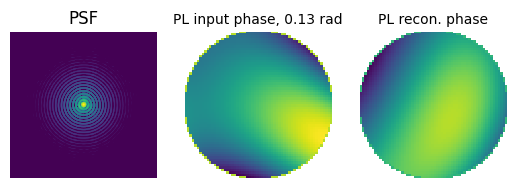

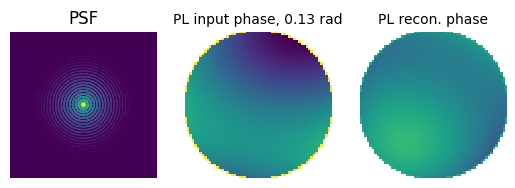

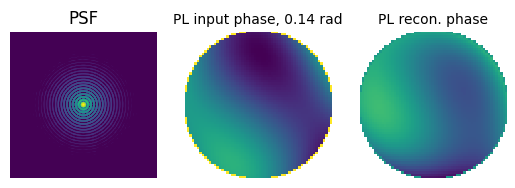

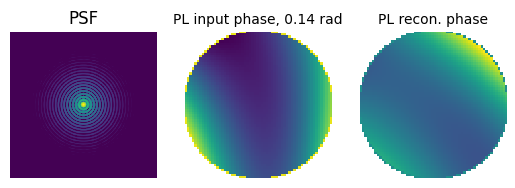

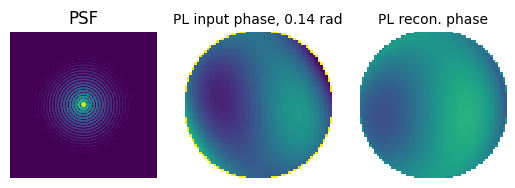

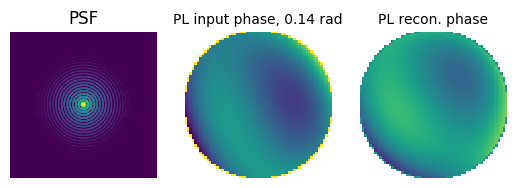

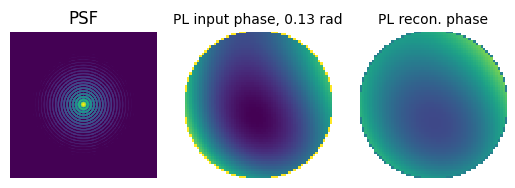

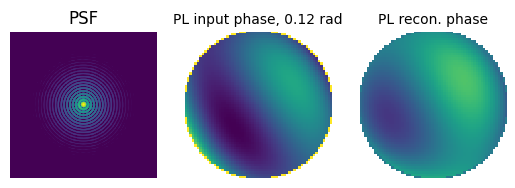

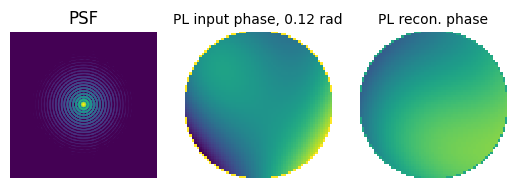

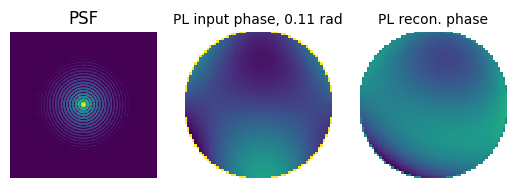

In [3]:
r0 = 0.5
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

100%|██████████| 200/200 [00:03<00:00, 54.59it/s]


Second-stage WF reconstruction, r0 = 0.1 m


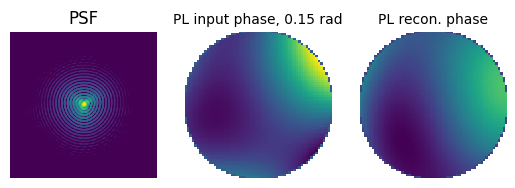

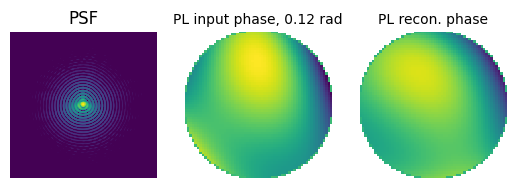

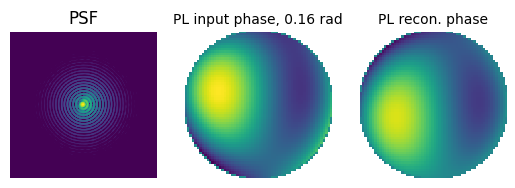

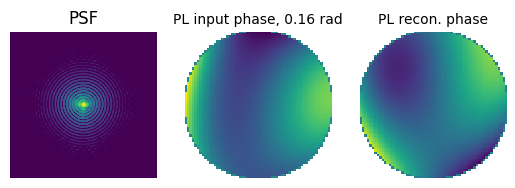

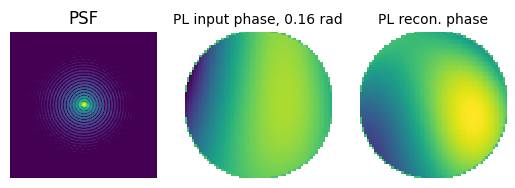

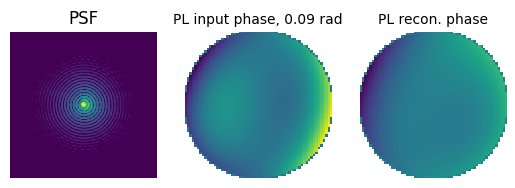

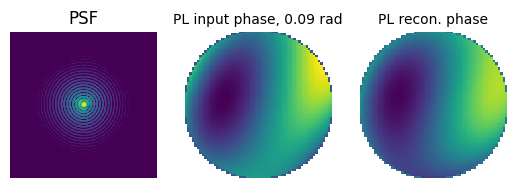

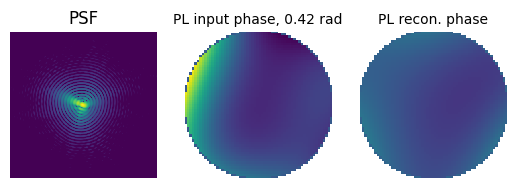

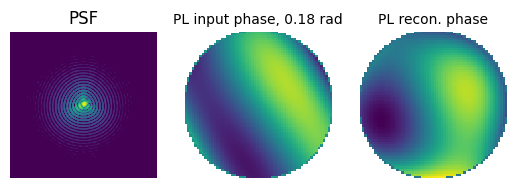

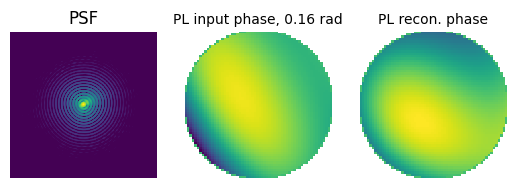

In [4]:
r0 = 0.1
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

100%|██████████| 200/200 [00:03<00:00, 57.26it/s]


Second-stage WF reconstruction, r0 = 0.01 m


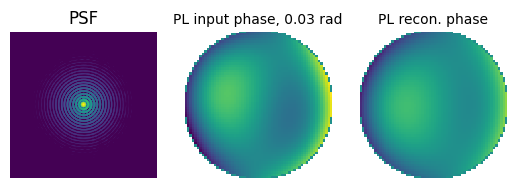

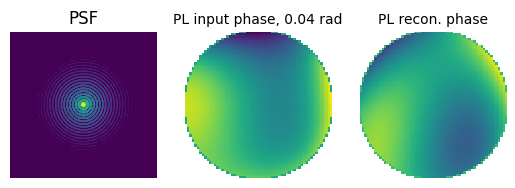

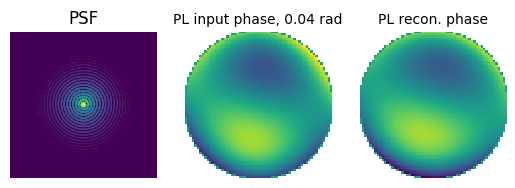

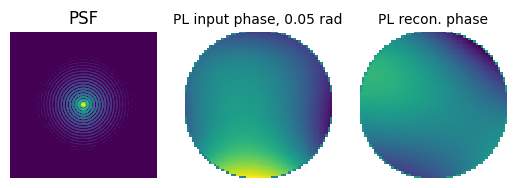

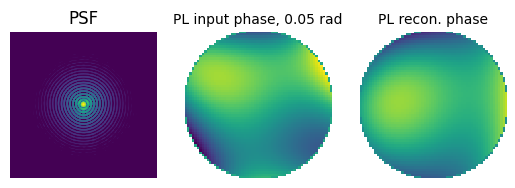

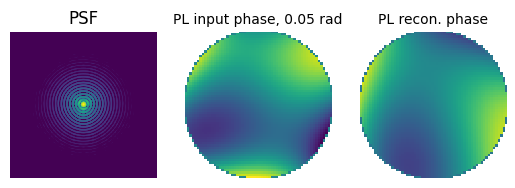

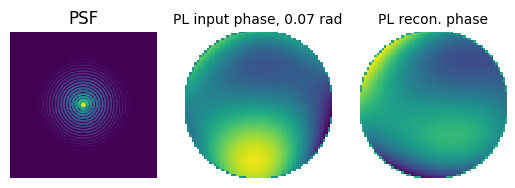

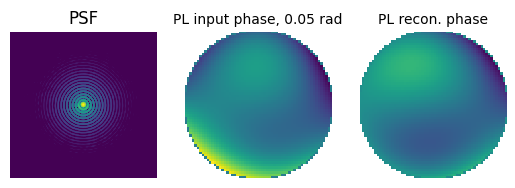

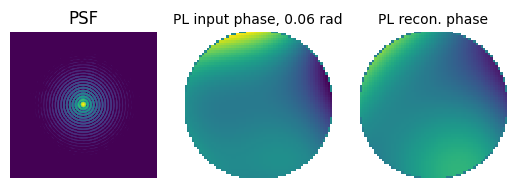

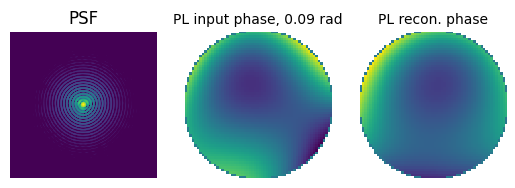

In [5]:
r0 = 0.01
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

100%|██████████| 200/200 [00:03<00:00, 59.38it/s]


Second-stage WF reconstruction, r0 = 0.01 m


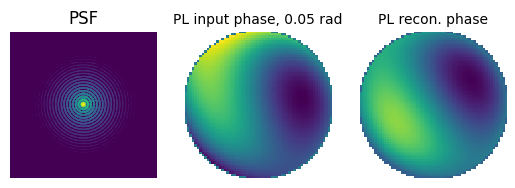

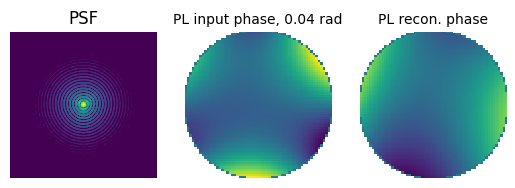

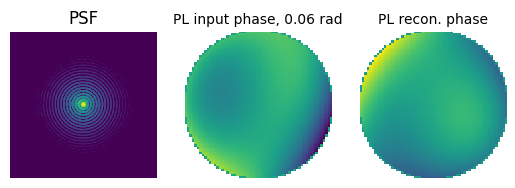

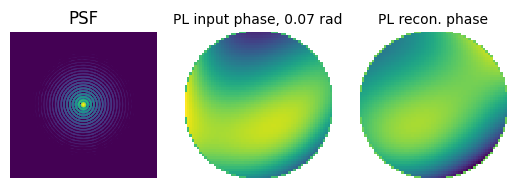

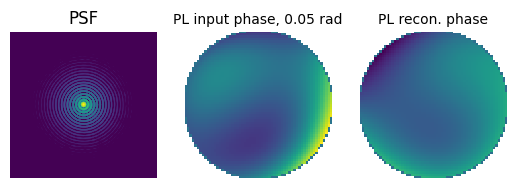

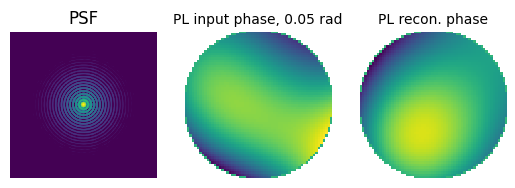

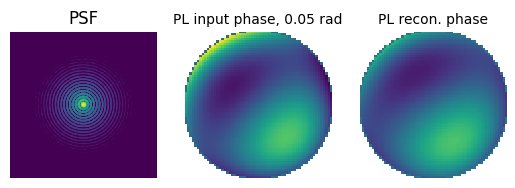

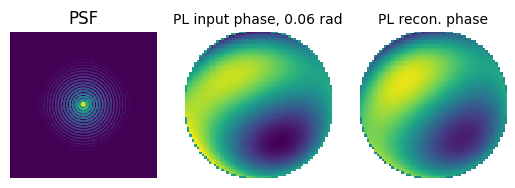

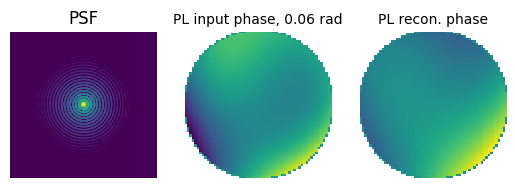

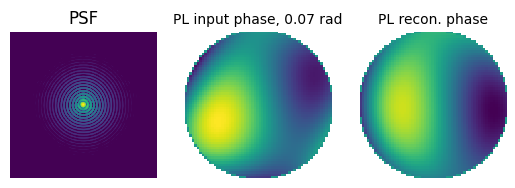

In [6]:
r0 = 0.01
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

100%|██████████| 200/200 [00:03<00:00, 57.82it/s]


Second-stage WF reconstruction, r0 = 0.1 m


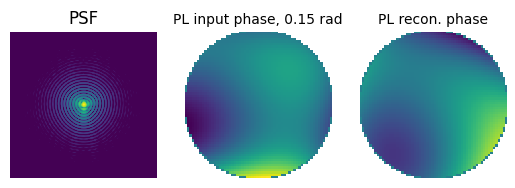

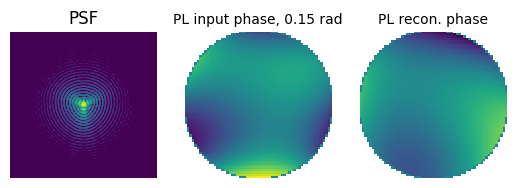

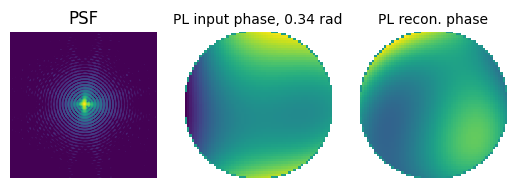

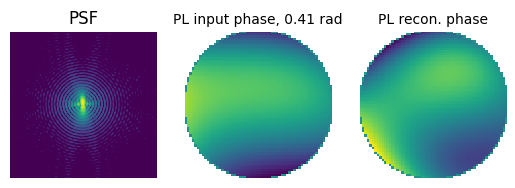

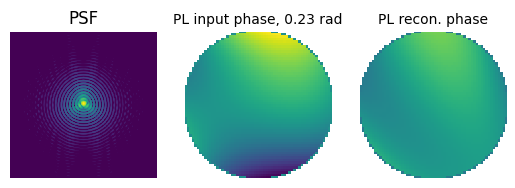

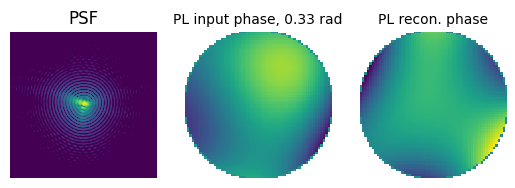

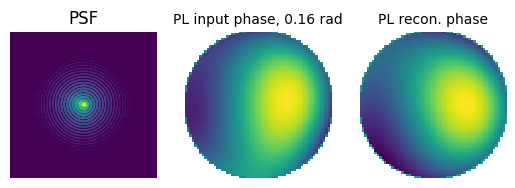

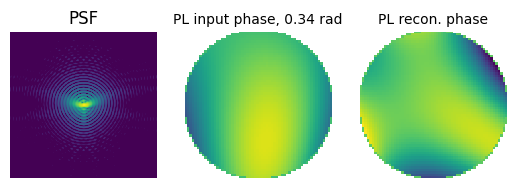

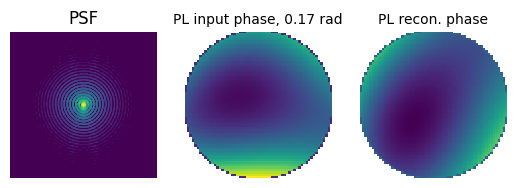

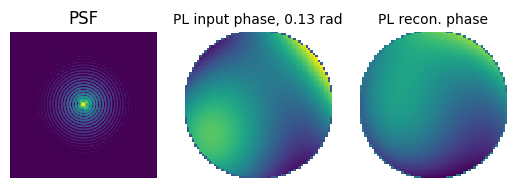

In [7]:
r0 = 0.1
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

100%|██████████| 200/200 [00:03<00:00, 61.45it/s]


Second-stage WF reconstruction, r0 = 0.5 m


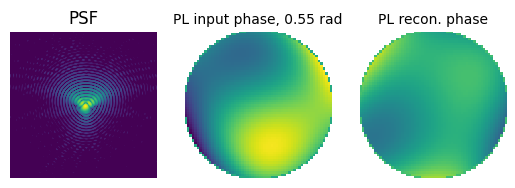

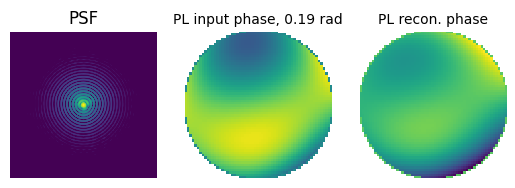

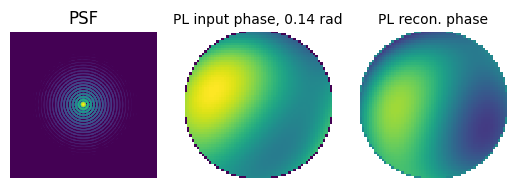

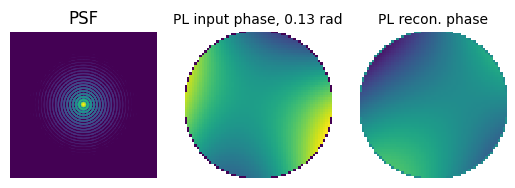

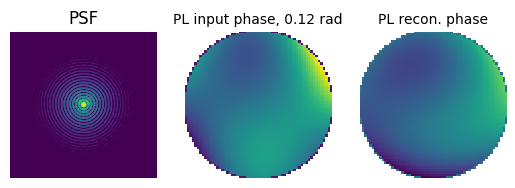

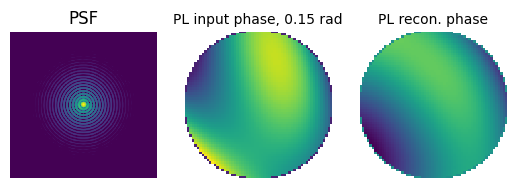

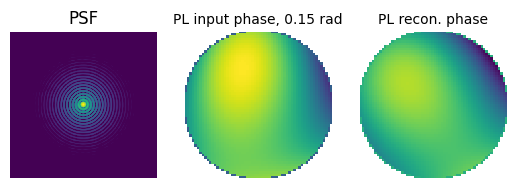

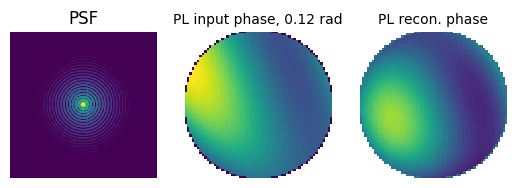

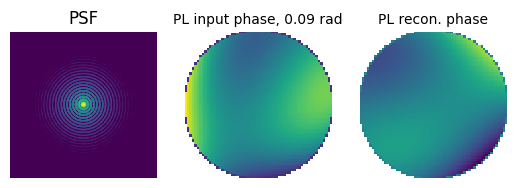

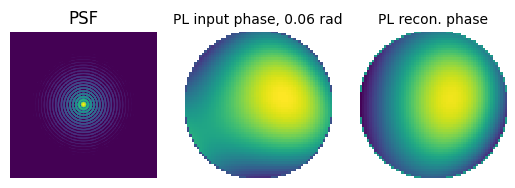

In [8]:
r0 = 0.5
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

100%|██████████| 200/200 [00:03<00:00, 58.53it/s]


Second-stage WF reconstruction, r0 = 0.1 m


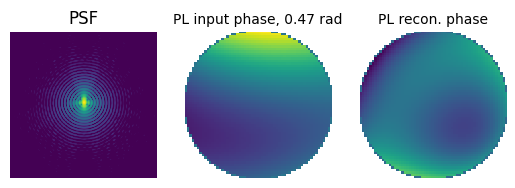

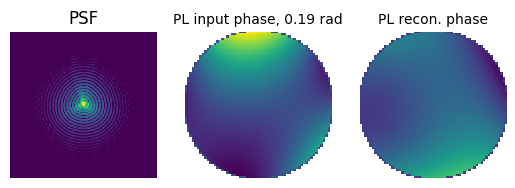

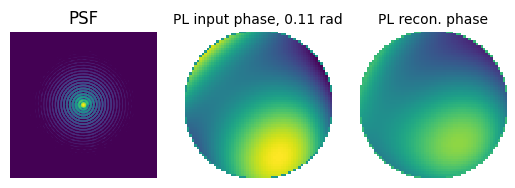

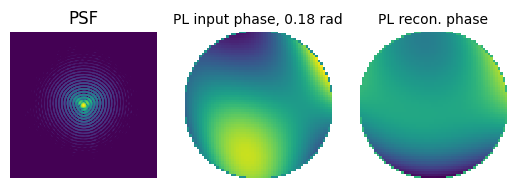

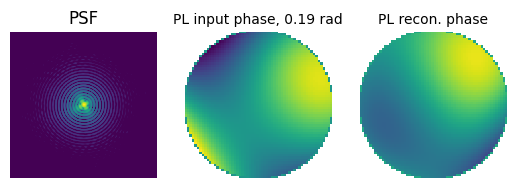

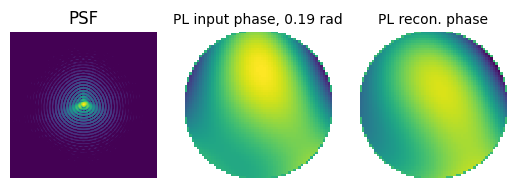

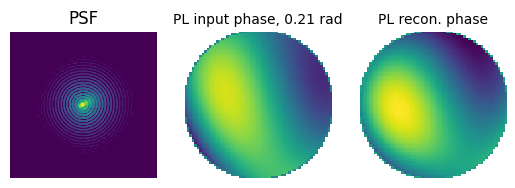

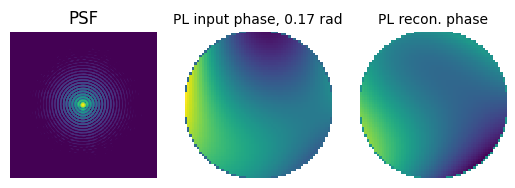

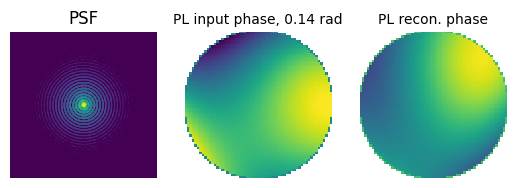

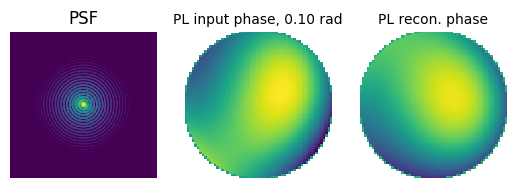

In [9]:
r0 = 0.1
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

In [10]:
lo.show_GS(3, -0.5, niter=10)

NameError: name 'lo' is not defined

In [11]:
from photonics.lantern_optics import LanternOptics

lo = LanternOptics(f_number=10.0)

100%|██████████| 10/10 [00:00<00:00, 18.01it/s]


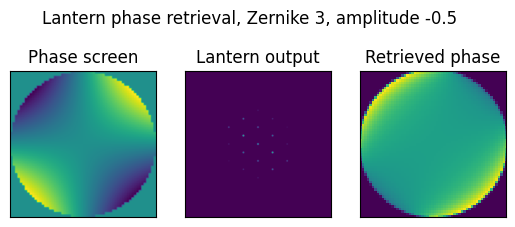

In [12]:
lo.show_GS(3, -0.5, niter=10)

No kernel connected

No kernel connected

Connected to .venv (Python 3.8.10)

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")
import os
if "CONDA_PREFIX" in os.environ:
    os.environ.__delitem__("CONDA_PREFIX")

import numpy as np
import hcipy as hc
from copy import copy
from matplotlib import pyplot as plt
from hcipy import imshow_field
from photonics import DATA_PATH
from photonics.utils import rms, lmap
from photonics.second_stage_optics import SecondStageOptics
from juliacall import Main as jl
jl.seval("using Flux")
jl.seval("using JLD2")

/home/lab/asengupta/photonics/.venv/lib/python3.8/site-packages/juliacall/__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
sso = SecondStageOptics()
max_amp_nn = 0.5
model_fname = f"pl_nn_{max_amp_nn}"
model_state = jl.JLD2.load(DATA_PATH + f"/pl_nn/{model_fname}.jld2", "model_state")
if model_fname.endswith("19"):
    nzern = 19
    model = jl.Chain(
        jl.Dense(19, 2000, jl.relu),
        jl.Dense(2000, 100, jl.relu),
        jl.Dropout(0.2),
        jl.Dense(100, 19)
    )
else:
    nzern = 9
    model = jl.Chain(
        jl.Dense(19, 2000, jl.relu),
        jl.Dense(2000, 100, jl.relu),
        jl.Dense(100, 9)
    )

jl.Flux.loadmodel_b(model, model_state)
ymin, ymax = (lambda x: (np.min(x), np.max(x)))(np.abs(np.load(DATA_PATH + "/sim_trainsets/sim_trainset_lanterns_240502_1947.npy")) ** 2)
zernike_basis = hc.mode_basis.make_zernike_basis(nzern, sso.telescope_diameter, sso.pupil_grid)

def nn_inject_recover(zernikes, amplitudes):
    phase_screen = sso.zernike_to_phase(zernikes, amplitudes)
    psf = sso.focal_propagator(
        hc.Wavefront(sso.aperture * np.exp(1j * phase_screen), sso.wl)
    )
    post_lantern_coeffs = sso.lantern_optics.lantern_coeffs(psf)
    intensities = np.abs(post_lantern_coeffs) ** 2
    norm_intensities = ((intensities - ymin) / (ymax - ymin)).astype(np.float32)
    reconstructed_zernike_coeffs = np.array(model(norm_intensities)) * 0.5 - 0.25
    return reconstructed_zernike_coeffs

def nanify(phase_screen):
    x = copy(phase_screen)
    x = x - np.mean(x)
    x[np.where(sso.aperture == 0)] = np.nan
    return hc.Field(x, phase_screen.grid)

def reconstruct(phase_screen, plot=True):
    """
    Takes in a post-DM phase screen and injects and recovers it from the lantern.
    """
    phase_screen_coeffs = zernike_basis.coefficients_for(phase_screen - np.mean(phase_screen))
    phase_screen_projected = zernike_basis.linear_combination(phase_screen_coeffs)
    psf = sso.focal_propagator(
        hc.Wavefront(sso.aperture * np.exp(1j * phase_screen_projected), sso.wl)
    )
    post_lantern_coeffs = sso.lantern_optics.lantern_coeffs(psf)
    intensities = np.abs(post_lantern_coeffs) ** 2
    norm_intensities = ((intensities - ymin) / (ymax - ymin)).astype(np.float32)
    reconstructed_zernike_coeffs = model(norm_intensities) 
    # sso.lantern_optics.command_matrix @ (np.abs(post_lantern_coeffs) ** 2 - sso.lantern_optics.flat_amp)
    reconstructed_phase = zernike_basis.linear_combination(max_amp_nn * np.array(reconstructed_zernike_coeffs) - max_amp_nn/2)
    
    if plot:
        _, axs = plt.subplots(1, 3)
        for ax in axs:
            ax.axis('off')
        projected_zeroed = nanify(phase_screen_projected)
        reconstructed_zeroed = nanify(reconstructed_phase)
        vmin = np.minimum(np.nanmin(projected_zeroed), np.nanmin(reconstructed_zeroed))
        vmax = np.maximum(np.nanmax(projected_zeroed), np.nanmax(reconstructed_zeroed))
        imshow_field(np.log10(psf.intensity / sso.norm), ax=axs[0], vmin=-5)
        axs[0].set_title("PSF")
        imshow_field(projected_zeroed, ax=axs[1], vmin=vmin, vmax=vmax)
        axs[1].set_title(f"PL input phase, {rms(phase_screen_coeffs):.2f} rad", fontsize=10)
        imshow_field(reconstructed_zeroed, ax=axs[2], vmin=vmin, vmax=vmax)
        axs[2].set_title("PL recon. phase", fontsize=10)
        plt.show()

100%|██████████| 81/81 [00:02<00:00, 40.03it/s]


100%|██████████| 200/200 [00:03<00:00, 54.98it/s]


Second-stage WF reconstruction, r0 = 0.1 m


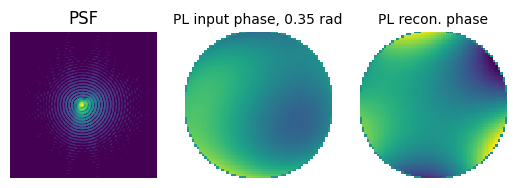

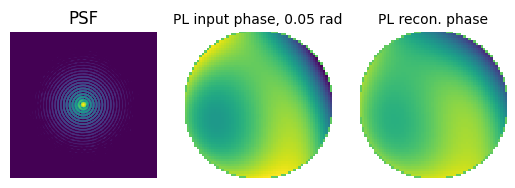

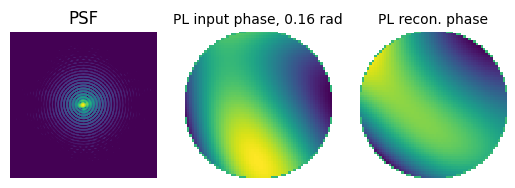

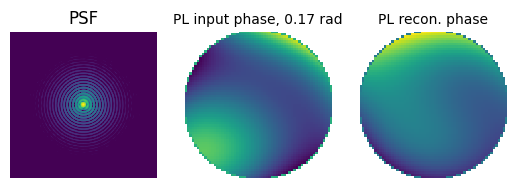

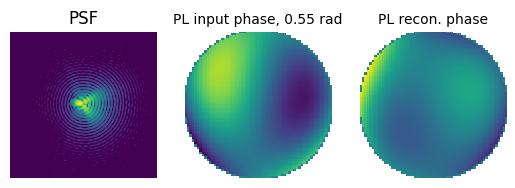

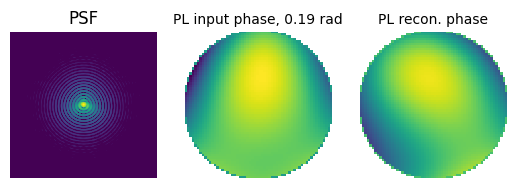

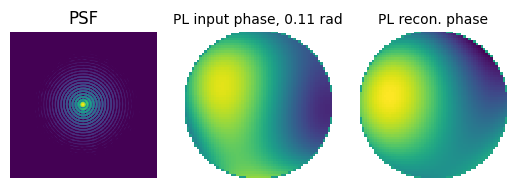

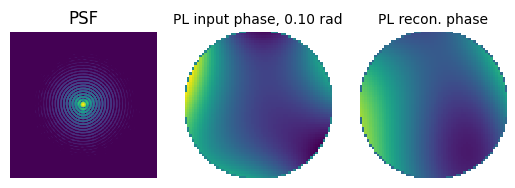

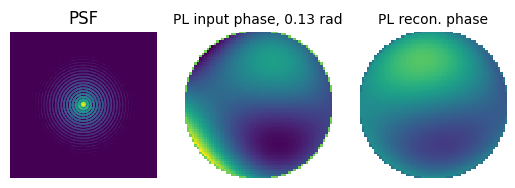

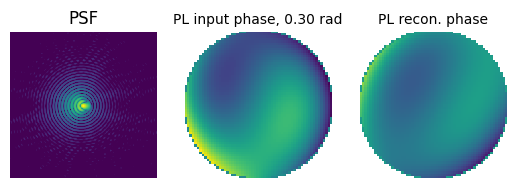

In [3]:
r0 = 0.1
sso.turbulence_setup(fried_parameter=r0)
correction_results = sso.pyramid_correction()
second_stage_phase_screens = [x.phase * sso.aperture for x in correction_results["wavefronts_after_dm"]]
print(f"Second-stage WF reconstruction, r0 = {r0} m")
for i in range(0, 200, 20):
    reconstruct(second_stage_phase_screens[i])

In [4]:
from IPython import get_ipython
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")

from photonics.second_stage_optics import SecondStageOptics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sso = SecondStageOptics()

In [6]:
sso.pyramid_correction()

100%|██████████| 200/200 [00:03<00:00, 56.32it/s]


{'wavefront_after_dm_errors': [1.6468615615175777,
  1.6402621411766047,
  1.6402308091609918,
  1.6465920942580765,
  1.655131285895271,
  1.6657846023026512,
  1.6751031363725928,
  1.6819776654137437,
  1.6768999326334035,
  1.6626208658343042,
  1.640270641697047,
  1.6147808118932792,
  1.5823993693722862,
  1.542380268894832,
  1.4992630144973362,
  1.4597384211950641,
  1.4272329048664887,
  1.3964620154621796,
  1.3737986186225624,
  1.3469758888387524,
  1.345039524660281,
  1.3373296435813955,
  1.3244596709349676,
  1.305815918938454,
  1.2827260326102288,
  1.2534611032380203,
  1.2165421357574469,
  1.1881945096119484,
  1.1528024436747761,
  1.1244813862856777,
  1.105000173401762,
  1.0934288941757666,
  1.0766835047280272,
  1.0616519875592865,
  1.0417471138403283,
  1.0182853289053242,
  0.999162845838949,
  0.9802053696163897,
  0.965184670123144,
  0.9476988059269328,
  0.937552539667687,
  0.9237273894262793,
  0.9182925941405411,
  0.9160192454928182,
  0.91705200

In [7]:
correction_results = sso.pyramid_correcti

AttributeError: 'SecondStageOptics' object has no attribute 'pyramid_correcti'

In [8]:
correction_results = sso.pyramid_correction()

100%|██████████| 200/200 [00:03<00:00, 54.67it/s]


In [9]:
correction_results

{'wavefront_after_dm_errors': [1.5120541534811671,
  1.516968634905536,
  1.529141558949859,
  1.5470753809396518,
  1.568823484203025,
  1.5854962727435964,
  1.6039012506639505,
  1.6196311973848534,
  1.6381368347616678,
  1.6576828717445882,
  1.6778200540524784,
  1.6971555768713131,
  1.7163850217616128,
  1.7409642484021646,
  1.766657786507825,
  1.7850099518149174,
  1.8027443614032281,
  1.8210449563000055,
  1.8354629309057122,
  1.8472013045632987,
  1.8506737623685532,
  1.8445690816020508,
  1.8462378223281524,
  1.8484940459554502,
  1.8587961026296542,
  1.871375678494381,
  1.8954875953446266,
  1.9254333078988723,
  1.9684565686523376,
  2.013277674424026,
  2.062936316468052,
  2.117009632439552,
  2.1864464248402973,
  2.2522839024654853,
  2.3155553738477495,
  2.368024437022844,
  2.361715040696555,
  2.24345540717058,
  1.9752378475160355,
  1.681293430451366,
  1.450313687582426,
  1.2814434485945714,
  1.1713827841999296,
  1.0999200505472748,
  1.0541498345259

In [10]:
keys(correction_results)

NameError: name 'keys' is not defined

In [11]:
(correction_results.keys)

<function dict.keys>

In [12]:
correction_results.keys()

dict_keys(['wavefront_after_dm_errors', 'wavefronts_after_dm', 'dm_shapes', 'point_spread_functions', 'strehl_ratios', 'phases_for'])

In [13]:
sso = SecondStageOptics()
zernike_basis = hc.mode_basis.make_zernike_basis(nzern, sso.telescope_diameter, sso.pupil_grid)

In [14]:
from IPython import get_ipython
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")

import hcipy as hc
from photonics.second_stage_optics import SecondStageOptics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
nzern = 9
sso = SecondStageOptics()
zernike_basis = hc.mode_basis.make_zernike_basis(nzern, sso.telescope_diameter, sso.pupil_grid)

In [16]:
[zernike_basis.coefficients_for(x.phase) for x in correction_results["wavefronts_after_dm"]]

[OldStyleField([-0.44592758,  0.33272327, -0.30582134, -0.30157844,
                -0.51218784, -0.10743872,  0.2578801 ,  0.48753153,
                -0.08627065]),
 OldStyleField([-0.35662439,  0.25688057, -0.33152788, -0.31961003,
                -0.57791568, -0.0912698 ,  0.26057352,  0.51171095,
                -0.16304616]),
 OldStyleField([-0.27552344,  0.19468278, -0.35833746, -0.28510774,
                -0.60487711, -0.05806158,  0.3061615 ,  0.5241732 ,
                -0.21254459]),
 OldStyleField([-0.20523803,  0.12600653, -0.39421562, -0.2585436 ,
                -0.63555409, -0.02592357,  0.34220947,  0.53488438,
                -0.26074641]),
 OldStyleField([-0.17034186,  0.02923528, -0.41979479, -0.2389299 ,
                -0.62531806, -0.02856651,  0.38145148,  0.5411817 ,
                -0.25832031]),
 OldStyleField([-0.205354  , -0.18232111, -0.43096294, -0.29702252,
                -0.58990058, -0.13883911,  0.4136943 ,  0.47003538,
                -0.21056592])

In [17]:
[np.array(zernike_basis.coefficients_for(x.phase)) for x in correction_results["wavefronts_after_dm"]

SyntaxError: unexpected EOF while parsing (<ipython-input-17-535605cb25c6>, line 2)

In [18]:
[np.array(zernike_basis.coefficients_for(x.phase)) for x in correction_results["wavefronts_after_dm"]]

[array([-0.44592758,  0.33272327, -0.30582134, -0.30157844, -0.51218784,
        -0.10743872,  0.2578801 ,  0.48753153, -0.08627065]),
 array([-0.35662439,  0.25688057, -0.33152788, -0.31961003, -0.57791568,
        -0.0912698 ,  0.26057352,  0.51171095, -0.16304616]),
 array([-0.27552344,  0.19468278, -0.35833746, -0.28510774, -0.60487711,
        -0.05806158,  0.3061615 ,  0.5241732 , -0.21254459]),
 array([-0.20523803,  0.12600653, -0.39421562, -0.2585436 , -0.63555409,
        -0.02592357,  0.34220947,  0.53488438, -0.26074641]),
 array([-0.17034186,  0.02923528, -0.41979479, -0.2389299 , -0.62531806,
        -0.02856651,  0.38145148,  0.5411817 , -0.25832031]),
 array([-0.205354  , -0.18232111, -0.43096294, -0.29702252, -0.58990058,
        -0.13883911,  0.4136943 ,  0.47003538, -0.21056592]),
 array([-0.20771017, -0.30139236, -0.44172154, -0.28494086, -0.54597594,
        -0.16765348,  0.46188048,  0.45358639, -0.16327014]),
 array([-0.23563066, -0.43719954, -0.44658148, -0.27417

In [19]:
np.array([np.array(zernike_basis.coefficients_for(x.phase)) for x in correction_results["wavefronts_after_dm"]])

array([[-0.44592758,  0.33272327, -0.30582134, ...,  0.2578801 ,
         0.48753153, -0.08627065],
       [-0.35662439,  0.25688057, -0.33152788, ...,  0.26057352,
         0.51171095, -0.16304616],
       [-0.27552344,  0.19468278, -0.35833746, ...,  0.3061615 ,
         0.5241732 , -0.21254459],
       ...,
       [ 0.73324181,  0.37492737, -0.26508604, ...,  0.02069523,
        -0.28406182, -0.23842284],
       [ 0.74091719,  0.45312208, -0.24632265, ...,  0.02705128,
        -0.26717987, -0.2026429 ],
       [ 0.75090386,  0.49996278, -0.24483186, ..., -0.01110753,
        -0.28130111, -0.19893772]])

In [20]:
focal_plane_coeffs_over_time = np.array([np.array(zernike_basis.coefficients_for(x.phase)) for x in correction_results["wavefronts_after_dm"]])

In [21]:
plot(focal_plane_coeffs_over_time)

NameError: name 'plot' is not defined

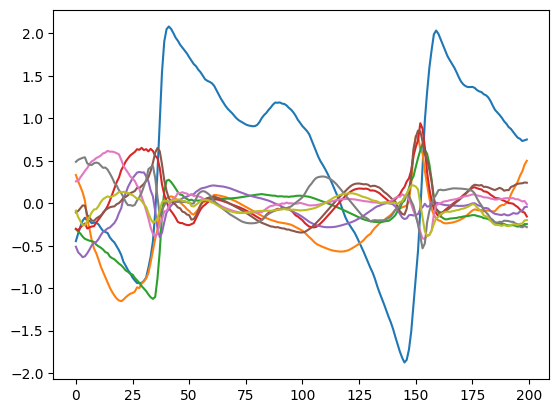

In [22]:
plt.plot(focal_plane_coeffs_over_time)

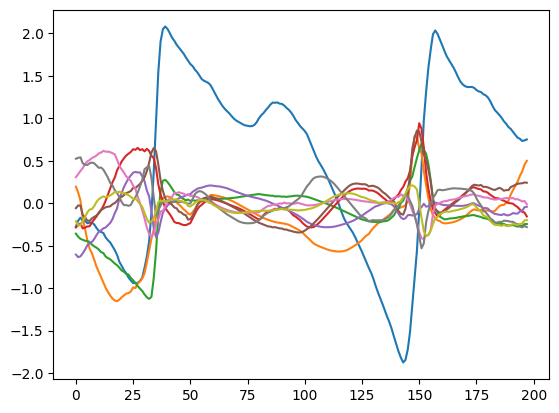

In [23]:
plt.plot(focal_plane_coeffs_over_time[2:,:])

In [24]:
correction_results = sso.pyramid_correction()

100%|██████████| 200/200 [00:03<00:00, 59.44it/s]


In [25]:
focal_plane_coeffs_over_time = np.array([np.array(zernike_basis.coefficients_for(x.phase)) for x in correction_results["wavefronts_after_dm"]])

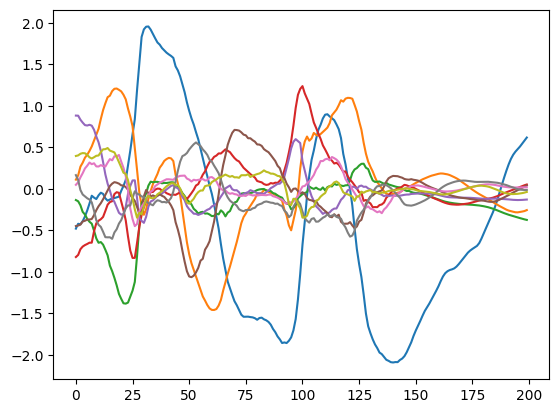

In [26]:
plt.plot(focal_plane_coeffs_over_time)

In [27]:
focal_plane_coeffs_over_time.shape

(200, 9)

In [28]:
plt.plot(focal_plane_coeffs_over_time[:,2:]

SyntaxError: unexpected EOF while parsing (<ipython-input-28-7969f84f022e>, line 2)

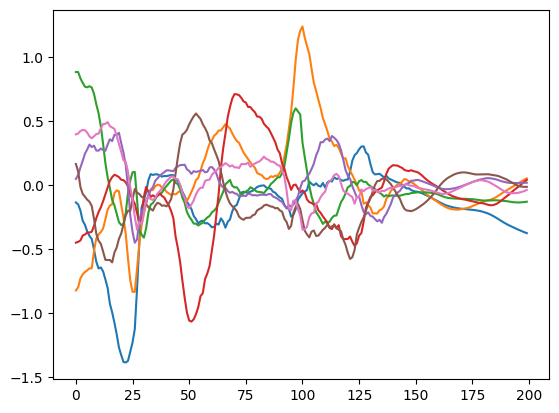

In [29]:
plt.plot(focal_plane_coeffs_over_time[:,2:])

In [30]:
sso.r0

AttributeError: 'SecondStageOptics' object has no attribute 'r0'

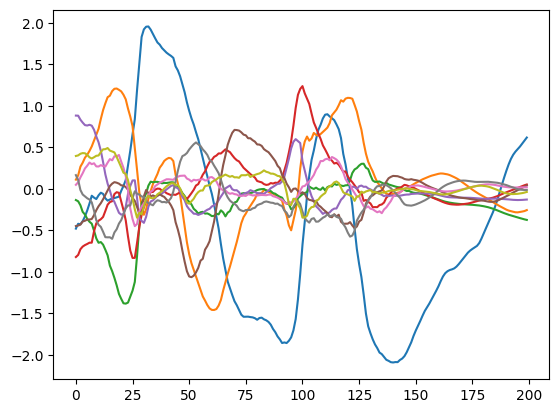

In [31]:
plt.plot(focal_plane_coeffs_over_time)

In [32]:
nstep = 200
correction_results = sso.pyramid_correction(num_iterations=nstep)

100%|██████████| 200/200 [00:03<00:00, 56.22it/s]


In [33]:
focal_plane_low_pass = np.zeros((nstep-1, nzern))
focal_plane_high_pass = np.zeros((nstep-1, nzern))

In [34]:
nstep = 200
f_loop = 100
correction_results = sso.pyramid_correction(num_iterations=nstep, dt=1/f_loop)

100%|██████████| 200/200 [00:03<00:00, 55.77it/s]


In [35]:
nzern = 9
f_cutoff = 30 # Hz

In [36]:
focal_plane_low_pass = np.zeros((nstep-1, nzern))
focal_plane_high_pass = np.zeros((nstep-1, nzern))

a = np.exp(-2 * np.pi * f_cutoff / f_loop)
for i in range(1, nstep):
    focal_plane_low_pass[i] = a * focal_plane_low_pass[i] + (1-a) * focal_plane_coeffs_over_time[i-1]
    focal_plane_high_pass[i] = focal_plane_coeffs_over_time[i] - (a * focal_plane_high_pass[i-1] + (1-a) * focal_plane_coeffs_over_time[i-1])

IndexError: index 199 is out of bounds for axis 0 with size 199

In [37]:
focal_plane_low_pass = np.zeros((nstep, nzern))
focal_plane_high_pass = np.zeros((nstep, nzern))

a = np.exp(-2 * np.pi * f_cutoff / f_loop)
for i in range(1, nstep):
    focal_plane_low_pass[i] = a * focal_plane_low_pass[i] + (1-a) * focal_plane_coeffs_over_time[i-1]
    focal_plane_high_pass[i] = focal_plane_coeffs_over_time[i] - (a * focal_plane_high_pass[i-1] + (1-a) * focal_plane_coeffs_over_time[i-1])

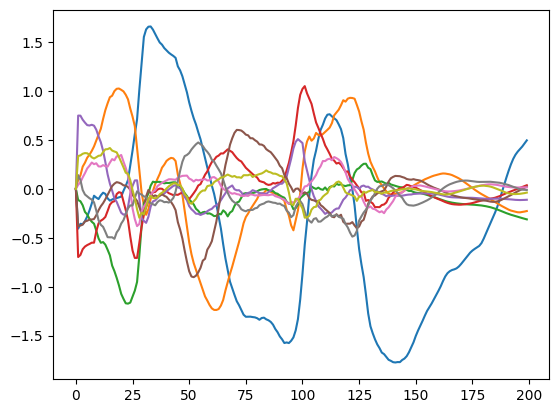

In [38]:
plt.plot(focal_plane_low_pass)

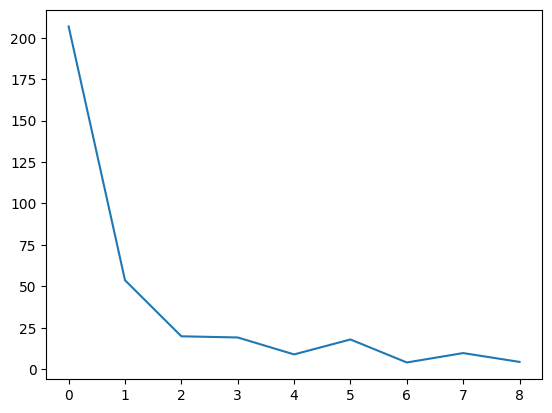

In [39]:
plt.plot(np.sum(focal_plane_low_pass ** 2, axis=0))

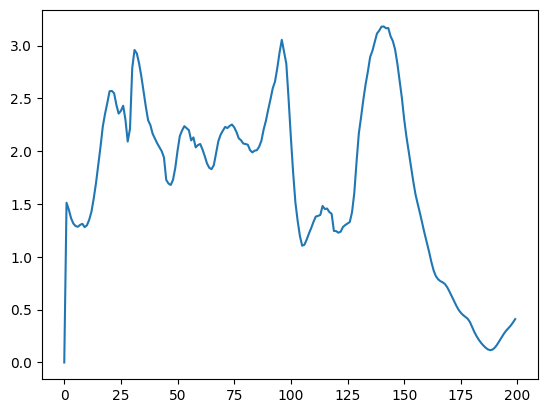

In [40]:
plt.plot(np.sum(focal_plane_low_pass ** 2, axis=1))

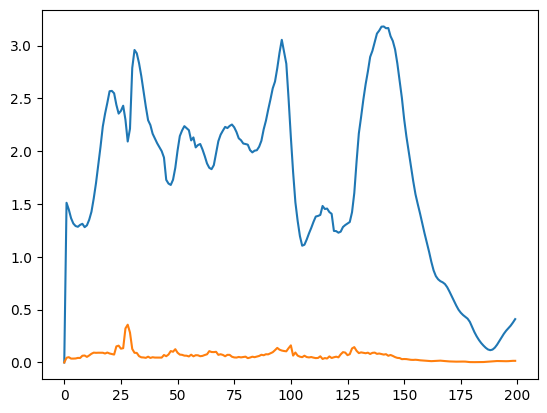

In [41]:
plt.plot(np.sum(focal_plane_low_pass ** 2, axis=1))
plt.plot(np.sum(focal_plane_high_pass ** 2, axis=1))

AttributeError: Line2D.set() got an unexpected keyword argument 'axis'

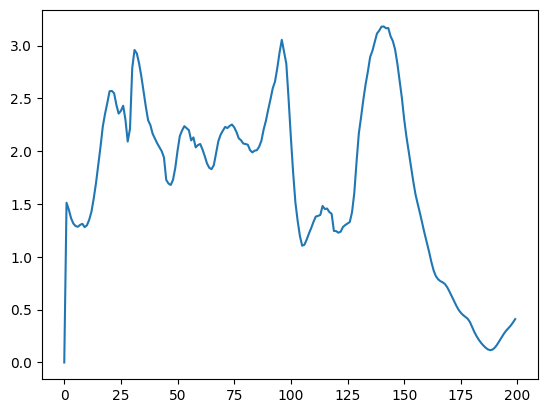

In [42]:
plt.plot(np.sum(focal_plane_low_pass ** 2, axis=1))
plt.plot(focal_plane_high_pass, axis=1)

AttributeError: Line2D.set() got an unexpected keyword argument 'axis'

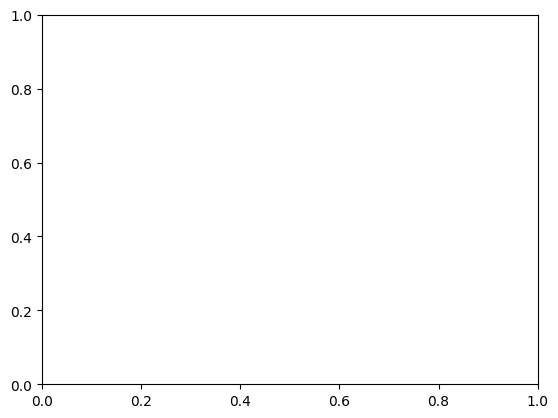

In [43]:
# plt.plot(np.sum(focal_plane_low_pass ** 2, axis=1))
plt.plot(focal_plane_high_pass, axis=1)

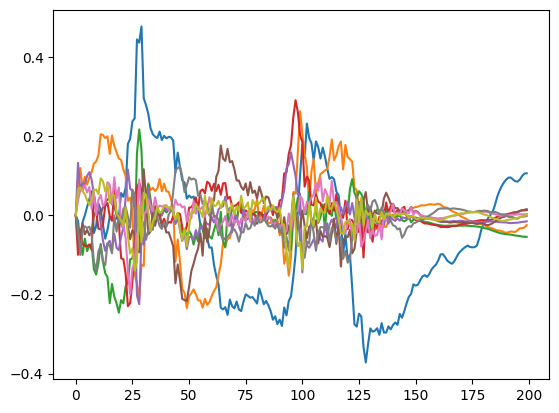

In [44]:
# plt.plot(np.sum(focal_plane_low_pass ** 2, axis=1))
plt.plot(focal_plane_high_pass)

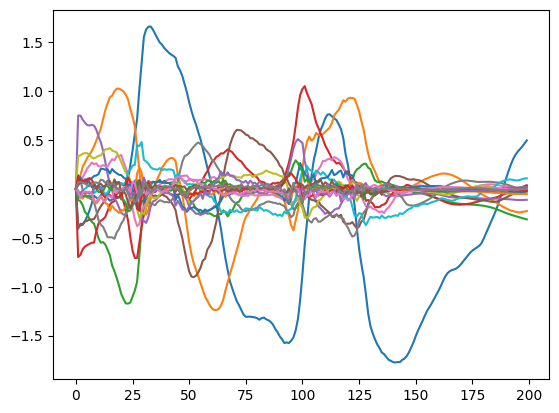

In [45]:
plt.plot(focal_plane_low_pass)
plt.plot(focal_plane_high_pass)

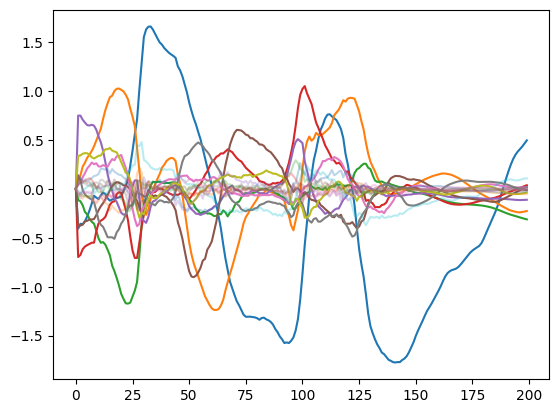

In [46]:
plt.plot(focal_plane_low_pass)
plt.plot(focal_plane_high_pass, alpha=0.3)

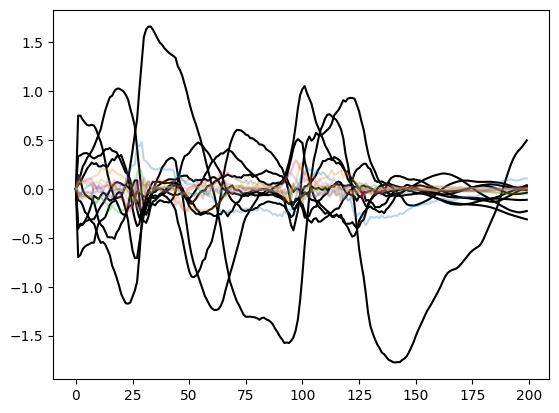

In [47]:
plt.plot(focal_plane_low_pass, color='k')
plt.plot(focal_plane_high_pass, alpha=0.3)

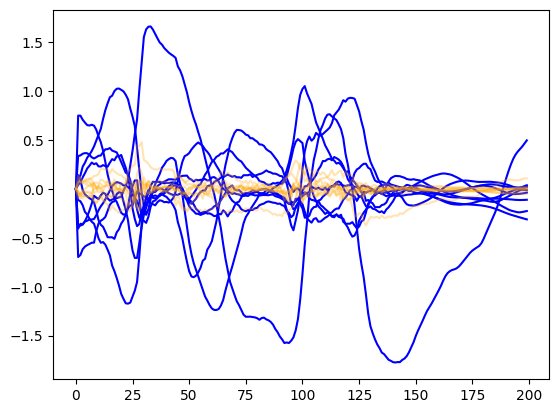

In [48]:
plt.plot(focal_plane_low_pass, color='blue')
plt.plot(focal_plane_high_pass, alpha=0.3, color='orange')

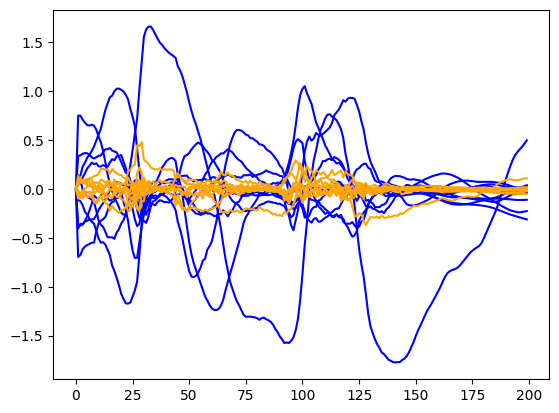

In [49]:
plt.plot(focal_plane_low_pass, color='blue')
plt.plot(focal_plane_high_pass, color='orange')

In [50]:
plt.plot(focal_plane_low_pass[:,5], color='blue')
plt.plot(focal_plane_high_pass[:,5], color='orange

SyntaxError: EOL while scanning string literal (<ipython-input-50-922c45075ca9>, line 3)

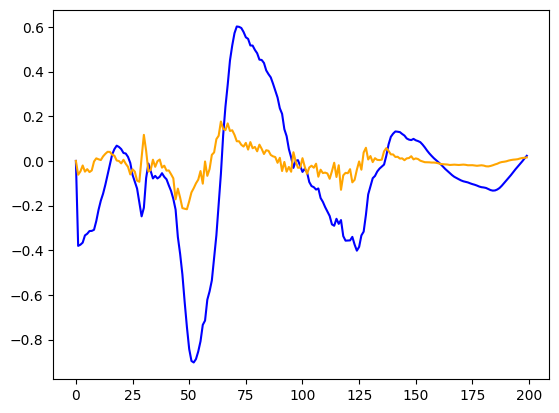

In [51]:
plt.plot(focal_plane_low_pass[:,5], color='blue')
plt.plot(focal_plane_high_pass[:,5], color='orange')

In [52]:
sso.deformable_mirror.influence_functions

In [53]:
sso.deformable_mirror.influence_functions.grid

In [54]:
sso.deformable_mirror.influence_functions.grid.x

array([-0.49166667, -0.475     , -0.45833333, ...,  0.45833333,
        0.475     ,  0.49166667])

In [55]:
sso.deformable_mirror.influence_functions.coefficients_for(zernike_basis[0])

array([ 0.08617648, -0.26314163,  0.33186394,  0.68968194,  0.78979248,
        0.68968194,  0.33186394, -0.26314163,  0.08617648, -0.26314163,
        0.72828721,  0.78139713,  0.55584846,  0.55007975,  0.55584846,
        0.78139713,  0.72828721, -0.26314163,  0.33186394,  0.78139713,
        0.44816859,  0.65886763,  0.60015859,  0.65886763,  0.44816859,
        0.78139713,  0.33186394,  0.68968194,  0.55584846,  0.65886763,
        0.58548084,  0.60159456,  0.58548084,  0.65886763,  0.55584846,
        0.68968194,  0.78979248,  0.55007975,  0.60015859,  0.60159456,
        0.61507442,  0.60159456,  0.60015859,  0.55007975,  0.78979248,
        0.68968194,  0.55584846,  0.65886763,  0.58548084,  0.60159456,
        0.58548084,  0.65886763,  0.55584846,  0.68968194,  0.33186394,
        0.78139713,  0.44816859,  0.65886763,  0.60015859,  0.65886763,
        0.44816859,  0.78139713,  0.33186394, -0.26314163,  0.72828721,
        0.78139713,  0.55584846,  0.55007975,  0.55584846,  0.78

In [56]:
lmap(sso.deformable_mirror.influence_functions.coefficients_for, zernike_basis)

[array([ 0.08617648, -0.26314163,  0.33186394,  0.68968194,  0.78979248,
         0.68968194,  0.33186394, -0.26314163,  0.08617648, -0.26314163,
         0.72828721,  0.78139713,  0.55584846,  0.55007975,  0.55584846,
         0.78139713,  0.72828721, -0.26314163,  0.33186394,  0.78139713,
         0.44816859,  0.65886763,  0.60015859,  0.65886763,  0.44816859,
         0.78139713,  0.33186394,  0.68968194,  0.55584846,  0.65886763,
         0.58548084,  0.60159456,  0.58548084,  0.65886763,  0.55584846,
         0.68968194,  0.78979248,  0.55007975,  0.60015859,  0.60159456,
         0.61507442,  0.60159456,  0.60015859,  0.55007975,  0.78979248,
         0.68968194,  0.55584846,  0.65886763,  0.58548084,  0.60159456,
         0.58548084,  0.65886763,  0.55584846,  0.68968194,  0.33186394,
         0.78139713,  0.44816859,  0.65886763,  0.60015859,  0.65886763,
         0.44816859,  0.78139713,  0.33186394, -0.26314163,  0.72828721,
         0.78139713,  0.55584846,  0.55007975,  0.5

In [57]:
zonal_to_modal = lmap(sso.deformable_mirror.influence_functions.coefficients_for, hc.mode_basis.make_zernike_basis(sso.deformable_mirror.num_actuators, sso.telescope_diameter, sso.pupil_grid))

In [58]:
zonal_to_modal = np.array(lmap(sso.deformable_mirror.influence_functions.coefficients_for, hc.mode_basis.make_zernike_basis(sso.deformable_mirror.num_actuators, sso.telescope_diameter, sso.pupil_grid)))

In [59]:
zonal_to_modal.shape

(81, 81)

In [60]:
zonal_to_modal = np.array(lmap(sso.deformable_mirror.influence_functions.coefficients_for, hc.mode_basis.make_zernike_basis(sso.deformable_mirror.num_actuators - 1, sso.telescope_diameter, sso.pupil_grid)))

In [61]:
zonal_to_modal.shape

(80, 81)

In [62]:
zonal_to_modal = np.linalg.inv(np.array(lmap(sso.deformable_mirror.influence_functions.coefficients_for, hc.mode_basis.make_zernike_basis(sso.deformable_mirror.num_actuators, sso.telescope_diameter, sso.pupil_grid)))) # num_actuators x num modes